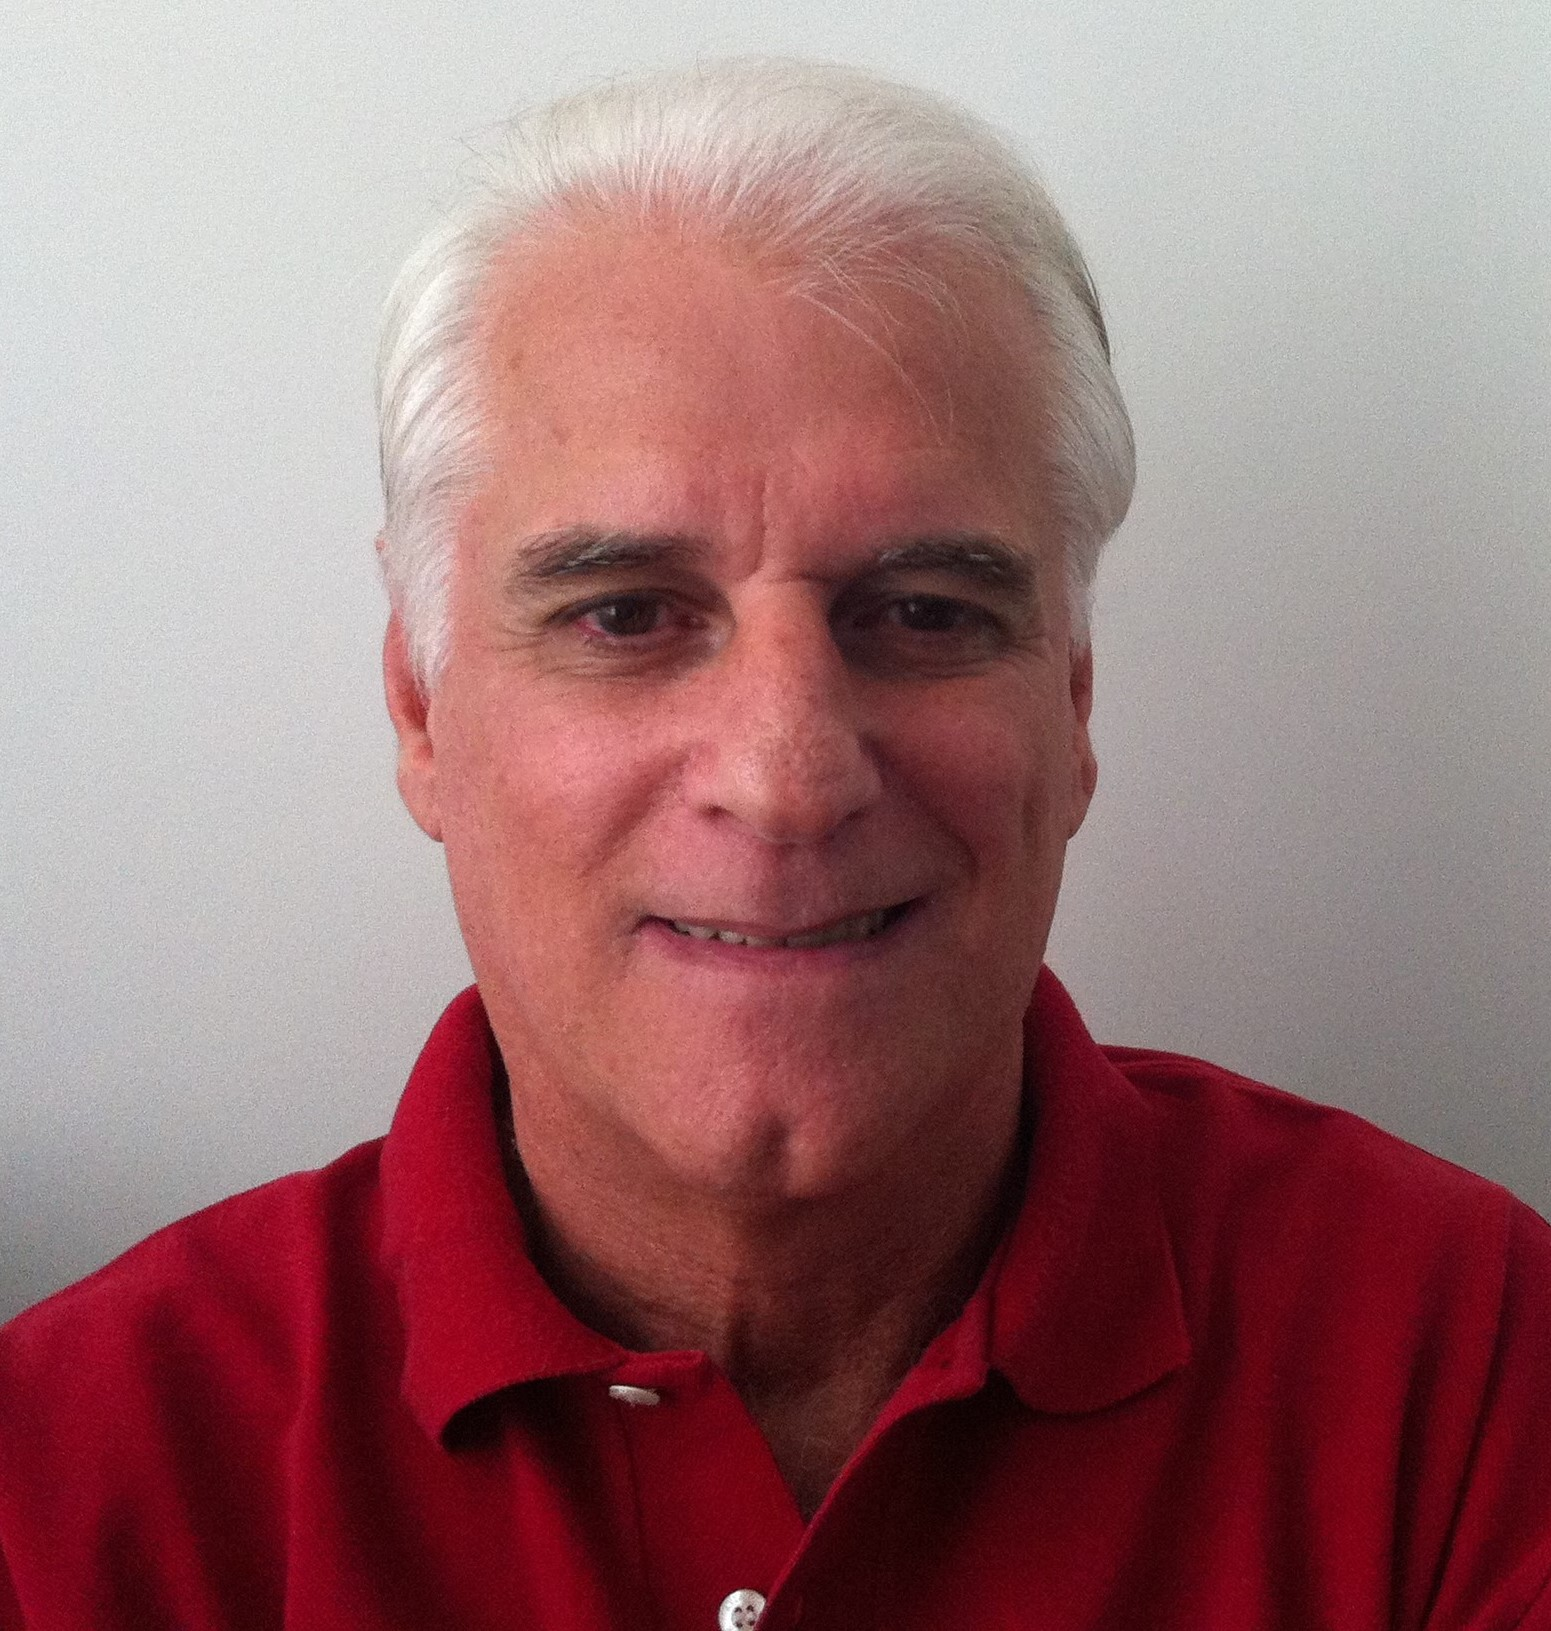

In [170]:
#@title Oi Pessoal. Bem vindos ao mundo dos portfólios diversificados
from IPython.display import Image 
pil_img = Image(filename='Beto-Kaggle_1.jpg', width=75, height=75)
display(pil_img)

HTML('''    
<p> Roberto Barberá </p>
<p> Rio de Janeiro - Brasil </p>
''')

# **Otimização de Portfólios - Ensaio com Fundos Imobiliários FIIs da B3**

O objetivo deste estudo é apenas didático e de exemplificar o uso da alocação de ativos de modo a obtermos um PORTFÓLIO DE VARIÂNCIA MÍNIMA, baseado nas cotações históricas do período pós decretação da pandemia de COVID-19.

**Fonte**: Yahoo Finance.

Passos: 

**1 .** Obtendo dados históricos diários

**2 .** Examinando da matriz de covariância dos Fiis.

**3 .** Simulação do Portfólio de variância mínima.

Os dados de entradas do modelo em estudo são os seguintes:

- lista de ativos componentes do portfólio a ser construído;
- valor total hipotécico de 100 mil unidades monetárias, a ser investido no portfólio como um todo, a fim de podermos estimar a quantidade física de cotas a serem adquiridas (alocacao quantitativa);

Obs.: este estudo inspirou-se no admirável trabalho de [Robert Andrew Martin](https://reasonabledeviations.com/)

In [172]:
#@title Installers

#%%capture
#!pip install yfinance

In [103]:
#@title Imports
# Infraestrutura de imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from datetime import datetime, timedelta

## **1 . Obtendo dados históricos diários dos FIIs fornecidos.**

In [58]:
# Definido ativos (para a pesquisa no Yahoo Finance é necessário acrescentar a extensão '.SA' nos tickers)

tickers = ['KNIP11.SA', 'KNRI11.SA', 'KNCR11.SA', 'HGLG11.SA', 'XPLG11.SA', 'IRDM11.SA', 'MXRF11.SA', 'HGRU11.SA', 'BRCR11.SA', 'HFOF11.SA', 'HGBS11.SA', 'XPML11.SA',
'JSRE11.SA', 'BBPO11.SA']
           
# Definindo o intervalo de datas para captura dos dados
ativoStartDate = "2021-03-15"
ativoEndDate = datetime.today()
end = ativoEndDate.strftime('%Y-%m-%d')

In [104]:
#@title Selecionando Preços de Fechamento
# Selecionando os preços de fechamento
suno30 = yf.download(tickers, start=ativoStartDate, end = end)

prices = suno30["Close"].copy()
prices

[*********************100%***********************]  14 of 14 completed


,BBPO11.SA,BRCR11.SA,HFOF11.SA,HGBS11.SA,HGLG11.SA,HGRU11.SA,IRDM11.SA,JSRE11.SA,KNCR11.SA,KNIP11.SA,KNRI11.SA,MXRF11.SA,XPLG11.SA,XPML11.SA
Date,,,,,,,,,,,,,,
2021-03-15,112.750000,81.900002,100.500000,199.960007,177.000000,124.580002,134.509995,90.849998,91.660004,115.750000,151.750000,10.36,115.000000,105.019997
2021-03-16,113.000000,81.660004,100.500000,199.500000,176.779999,123.300003,135.649994,90.769997,91.470001,114.000000,151.039993,10.33,113.599998,104.500000
2021-03-17,113.500000,81.529999,100.199997,201.490005,176.199997,124.000000,135.500000,89.610001,91.809998,114.400002,149.660004,10.33,113.500000,104.250000
2021-03-18,113.500000,81.500000,100.500000,198.000000,175.199997,122.760002,135.199997,89.699997,92.449997,113.779999,147.479996,10.29,112.900002,103.900002
2021-03-19,113.769997,81.540001,100.430000,199.020004,171.500000,123.849998,135.410004,91.790001,93.410004,114.139999,146.389999,10.33,113.040001,104.180000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-09,113.800003,78.900002,91.000000,194.699997,165.050003,118.150002,117.599998,88.000000,92.349998,106.849998,135.460007,10.00,106.699997,102.699997
2021-08-10,113.650002,78.040001,90.110001,193.660004,164.899994,117.550003,116.150002,87.540001,92.500000,106.699997,134.600006,10.01,106.000000,102.879997
2021-08-11,113.160004,76.949997,91.000000,192.000000,165.910004,116.750000,111.849998,86.989998,93.000000,107.089996,134.419998,9.98,104.000000,102.809998


- Verificando ausência de dados:

In [105]:
#@title Exibe Número de ativos sem dados (c/ respectivas quantidades nulas)
FDepura = prices.isna().sum()


In [61]:
FDepura

BBPO11.SA    0
BRCR11.SA    0
HFOF11.SA    0
HGBS11.SA    0
HGLG11.SA    0
HGRU11.SA    0
IRDM11.SA    0
JSRE11.SA    0
KNCR11.SA    0
KNIP11.SA    0
KNRI11.SA    0
MXRF11.SA    0
XPLG11.SA    0
XPML11.SA    0
dtype: int64

**Obs**.: todos os fundos escolhidos possuem dados no período considerado (pós COVID-19)

In [107]:
#@title Selecionando Ativos com Dados Completos
cols_completas = [i for i in tickers if FDepura[i] == 0]
tickers = cols_completas
# Selecionando apenas os fundos que possuem dados completos
prices = prices[cols_completas]
prices.tail()

,KNIP11.SA,KNRI11.SA,KNCR11.SA,HGLG11.SA,XPLG11.SA,IRDM11.SA,MXRF11.SA,HGRU11.SA,BRCR11.SA,HFOF11.SA,HGBS11.SA,XPML11.SA,JSRE11.SA,BBPO11.SA
Date,,,,,,,,,,,,,,
2021-08-09,106.849998,135.460007,92.349998,165.050003,106.699997,117.599998,10.00,118.150002,78.900002,91.000000,194.699997,102.699997,88.000000,113.800003
2021-08-10,106.699997,134.600006,92.500000,164.899994,106.000000,116.150002,10.01,117.550003,78.040001,90.110001,193.660004,102.879997,87.540001,113.650002
2021-08-11,107.089996,134.419998,93.000000,165.910004,104.000000,111.849998,9.98,116.750000,76.949997,91.000000,192.000000,102.809998,86.989998,113.160004
2021-08-12,106.849998,135.000000,91.550003,165.839996,102.750000,109.000000,9.91,115.010002,76.449997,90.489998,191.500000,102.720001,86.989998,112.830002
2021-08-13,107.269997,133.500000,91.720001,166.240005,103.000000,113.449997,10.00,117.889999,77.250000,89.949997,193.350006,102.660004,86.199997,112.989998


- Verificando outliers (discrepâncias nos dados)

In [108]:
#@title Outliers
prices.max()

KNIP11.SA    115.949997
KNRI11.SA    153.470001
KNCR11.SA     94.940002
HGLG11.SA    177.000000
XPLG11.SA    116.180000
IRDM11.SA    141.350006
MXRF11.SA     10.660000
HGRU11.SA    124.580002
BRCR11.SA     85.459999
HFOF11.SA    100.699997
HGBS11.SA    207.839996
XPML11.SA    108.190002
JSRE11.SA     95.199997
BBPO11.SA    116.279999
dtype: float64

Obs.: sem outliers

### **Verificando Visualmente Dados dos FIIs**

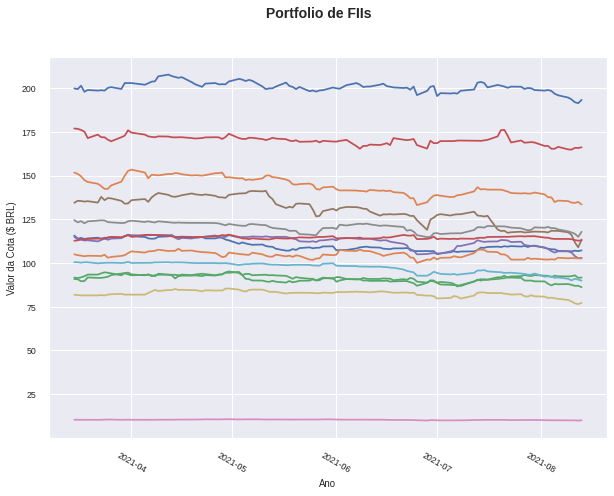

In [109]:
#@title Visualizando a dados históricos dos ativos
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig1, ax =plt.subplots(1,1,figsize=(10,7))
fig1.suptitle("Portfolio de FIIs", fontsize='14', fontweight='bold')
plt.style.use('seaborn');
##plt.xticks(rotation=-30)
labels = prices.columns

ax.tick_params(axis='x', rotation=-30)
# ax = prices[prices.index >= "2020-07-01"].plot(figsize=(10,8));
ax.set_xlabel("Ano");
ax.set_ylabel("Valor da Cota ($ BRL)");
ax.legend(prices, loc='upper left', fontsize=8);
# ax.set_title("Portfólio de FIIs do SUNO30 com Dados desde 2016", fontsize="12", fontweight='bold')
ax.plot(prices[prices.index >= "2020-07-01"])

plt.savefig("g-00.svg")
plt.show();

In [110]:
#@title Instaladores e Otimizadores 
%%capture
# !pip install PyPortfolioOpt

import pypfopt
from pypfopt import risk_models
from pypfopt import plotting

## **2 . Examinando a Matriz de Covariância da Carteira**

- Calculando e exibindo a matriz de covariância amostral dos FIIs do SUNO30

In [111]:
#@title Matrix de Covariância Anual
sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

,KNIP11.SA,KNRI11.SA,KNCR11.SA,HGLG11.SA,XPLG11.SA,IRDM11.SA,MXRF11.SA,HGRU11.SA,BRCR11.SA,HFOF11.SA,HGBS11.SA,XPML11.SA,JSRE11.SA,BBPO11.SA
KNIP11.SA,0.008694,0.001973,0.000410,0.000591,0.001587,-0.000878,0.002404,0.002552,0.000696,0.002617,0.002008,0.001617,0.003350,0.002060
KNRI11.SA,0.001973,0.018040,0.000420,0.004440,0.006363,0.003493,0.002444,0.002651,0.001899,0.005125,0.004962,0.005851,0.004302,0.002117
KNCR11.SA,0.000410,0.000420,0.014016,0.000661,0.001655,0.004248,0.004531,0.004759,0.002904,0.002301,0.002662,0.002422,0.002906,0.001445
HGLG11.SA,0.000591,0.004440,0.000661,0.016357,0.003924,0.001724,0.003603,0.001850,0.001588,0.002348,0.001541,0.003943,0.002633,0.001740
XPLG11.SA,0.001587,0.006363,0.001655,0.003924,0.013235,0.004292,0.003425,0.006119,0.004155,0.002970,0.004473,0.006739,0.004500,0.002357
IRDM11.SA,-0.000878,0.003493,0.004248,0.001724,0.004292,0.049201,0.006888,0.009480,0.005592,0.002706,0.001017,0.002946,-0.000941,0.001366
MXRF11.SA,0.002404,0.002444,0.004531,0.003603,0.003425,0.006888,0.007780,0.003855,0.003760,0.003626,0.002812,0.003353,0.002936,0.002383
HGRU11.SA,0.002552,0.002651,0.004759,0.001850,0.006119,0.009480,0.003855,0.012927,0.003380,0.003440,0.003000,0.007021,0.002127,0.001790
BRCR11.SA,0.000696,0.001899,0.002904,0.001588,0.004155,0.005592,0.003760,0.003380,0.011022,0.002411,0.004450,0.004028,0.003705,0.001824
HFOF11.SA,0.002617,0.005125,0.002301,0.002348,0.002970,0.002706,0.003626,0.003440,0.002411,0.006899,0.002735,0.004032,0.003268,0.002347


- Visualizando a matriz de covariância dos retornos anuais

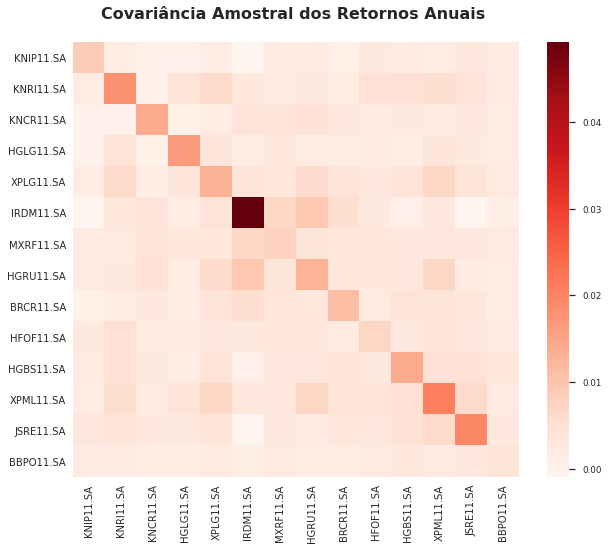

In [112]:
#@title Visualizando Heatmap Covar Retornos Anuais
# Visualizando as correlações do retornos anuais via heatmap
import pandas.testing
import seaborn as sns
plt.figure(figsize = (10,8))
plt.title('Covariância Amostral dos Retornos Anuais \n',
          fontsize=16, fontweight='bold')
sns.set(font_scale=0.8)
sns.heatmap(sample_cov, annot=False, cmap="Reds")
#plt.savefig("g-01-cov_ret.svg")
#sns.heatmap(sample_cov, annot=False, cmap="YlGnBu");
##sns.heatmap(sample_cov, annot=False, vmin=0, vmax=0.05);
plt.show()

Uma opção melhor do que a matrix de covariância amostral clássica, é a covariância de Ledoit-Wolf (fórmula de encolhimento) que reduz os valores extremos da matriz de covariância.

In [113]:
#@title Matriz de Covariância de Ledoit-Wolf
# Computando e mostrando a Matriz de covariância de Ledoit-Wolf que é a usada
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
S

,KNIP11.SA,KNRI11.SA,KNCR11.SA,HGLG11.SA,XPLG11.SA,IRDM11.SA,MXRF11.SA,HGRU11.SA,BRCR11.SA,HFOF11.SA,HGBS11.SA,XPML11.SA,JSRE11.SA,BBPO11.SA
KNIP11.SA,0.010222,0.001488,0.000309,0.000445,0.001197,-0.000662,0.001813,0.001924,0.000525,0.001973,0.001514,0.001219,0.002526,0.001553
KNRI11.SA,0.001488,0.017269,0.000317,0.003348,0.004798,0.002634,0.001843,0.001999,0.001432,0.003865,0.003742,0.004412,0.003244,0.001596
KNCR11.SA,0.000309,0.000317,0.014235,0.000498,0.001248,0.003203,0.003416,0.003588,0.002190,0.001735,0.002007,0.001826,0.002191,0.001089
HGLG11.SA,0.000445,0.003348,0.000498,0.016000,0.002959,0.001300,0.002717,0.001395,0.001198,0.001770,0.001162,0.002973,0.001985,0.001312
XPLG11.SA,0.001197,0.004798,0.001248,0.002959,0.013646,0.003237,0.002582,0.004614,0.003133,0.002240,0.003373,0.005082,0.003393,0.001777
IRDM11.SA,-0.000662,0.002634,0.003203,0.001300,0.003237,0.040766,0.005194,0.007149,0.004217,0.002041,0.000767,0.002221,-0.000709,0.001030
MXRF11.SA,0.001813,0.001843,0.003416,0.002717,0.002582,0.005194,0.009532,0.002907,0.002835,0.002734,0.002121,0.002529,0.002214,0.001797
HGRU11.SA,0.001924,0.001999,0.003588,0.001395,0.004614,0.007149,0.002907,0.013414,0.002549,0.002594,0.002262,0.005294,0.001604,0.001350
BRCR11.SA,0.000525,0.001432,0.002190,0.001198,0.003133,0.004217,0.002835,0.002549,0.011977,0.001818,0.003355,0.003037,0.002794,0.001375
HFOF11.SA,0.001973,0.003865,0.001735,0.001770,0.002240,0.002041,0.002734,0.002594,0.001818,0.008869,0.002062,0.003041,0.002464,0.001770


- Exibindo a matriz de covariância Ledoit-Wolf em heatmap

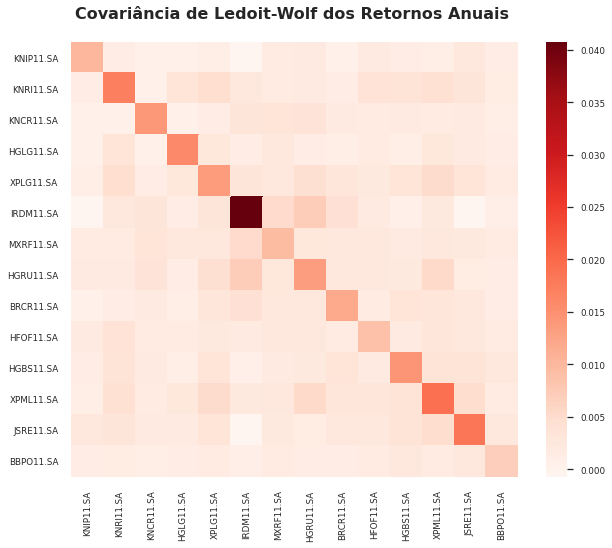

In [114]:
#@title Visualizando Heatmap Covariância de Ledoit-Wolf
# Visualizando as correlações do retornos anuais via heatmap
import seaborn as sns
plt.figure(figsize = (10,8))
plt.title('Covariância de Ledoit-Wolf dos Retornos Anuais \n',
          fontsize=16, fontweight='bold')
sns.set(font_scale=0.80)
#sns.heatmap(sample_cov, annot=True, cmap="YlGnBu")
#sns.heatmap(sample_cov, annot=True, cmap="YlGnBu")
sns.heatmap(S, annot=False, cmap="Reds")
plt.savefig("g-01-cov_ret.svg")
##sns.heatmap(S, annot=False, vmin=0, vmax=0.05);
plt.show()

- Estimação do retorno anual das cotas dos FIIs

A experiência mostra que há imprecisões e muita subjetividade ao estimarmos os retornos baseados na média dos retornos passados. 

Há uma alternativa menos ruim que é do uso do encolhimento de James-Stein, ou retornos CAPM (Capital Asset Pricing Model), que apresenta estabilidade maior do que o retorno histórico médio.

In [115]:
#@title Expectativa de Retornos
from pypfopt import expected_returns
# mu_ExR = expected_returns.capm_return(prices)
mu_ExR = expected_returns.mean_historical_return(prices)

perc_ret = np.round((mu_ExR.values*100), decimals=2)
# perc_ret
'''
import pprint 
pp = pprint.PrettyPrinter(indent=4)
print(f"Retornos Anuais Estimados por ativo em percentuais")
pp.pprint(perc_ret)
''';

- Plotando os retornos anuais esperados, por FII

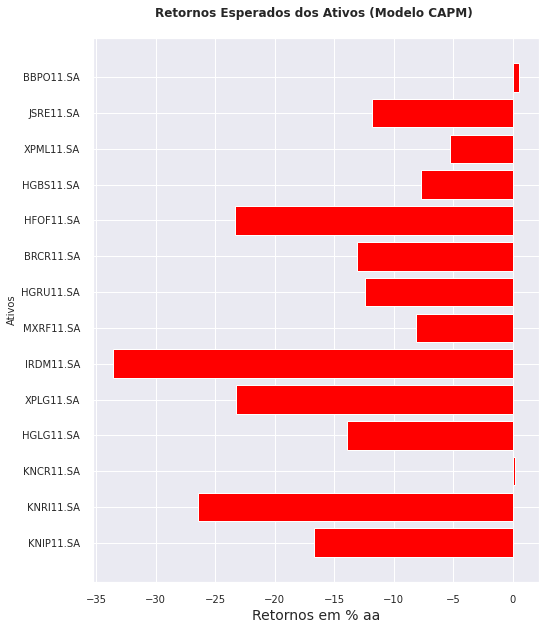

In [116]:
#@title Visualizando Retornos Esperados
from itertools import cycle, islice

plt.figure(figsize=(8, 10))
plt.title('Retornos Esperados dos Ativos (Modelo CAPM) \n', fontsize=12,
          fontweight='bold')
plt.xlabel("Retornos em % aa", fontsize = 14)
plt.ylabel("Ativos", fontsize = 10)
# my_colors = list(islice(cycle(['LightBlue','Blue','DarkBlue','Black']), None, 
                     # len(mu_ExR)))

xrange = range(len(mu_ExR))
yrange = np.round((mu_ExR.values*100),2)

plt.xticks(fontsize = 10, rotation = 0)
plt.yticks(xrange, mu_ExR.index.values, fontsize=10)
plt.barh(xrange, np.round((mu_ExR.values*100), decimals=2), color='Red')
#plt.barh(xrange, np.round((mu_ExR.values*100), decimals=1), 
#         color=cm.Reds(np.round((mu_ExR.values*100), decimals=2)/len(mu_ExR)) )
plt.savefig("g-02-ret_CAPM")

plt.show()

## **3 . Simulação do Portfólio de VARIÂNCIA MÍNIMA**

- Minimizando a variância global (GMV), que é mais robusta do que a variância média, obtivemos os pesos abaixo, para cada ativo componente do portfólio.

In [117]:
#@title Portfólio de Variância Mínima
from pypfopt import EfficientFrontier
import warnings

warnings.filterwarnings('ignore')

#@title Pesos Obtidos a Partir da Fronteira Eficiente de Markowitz
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
#
# Usando a teoria da fronteira eficiente de Markowitz
# Neste caso não é necessário fornecer os retornos esperados
# o que é muito bom.
#
# É normal que alguns pesos apareçam zerados, indicando que o ativo 
# correspondente adiciona risco, sem necessariamente aumentar o
# retorno.

#ef = EfficientFrontier(None, S, weight_bounds=(None, None))
ef = EfficientFrontier(None, S, weight_bounds=(-1, 1))
ef.min_volatility()
weights = ef.clean_weights();
'''
# percorre o dicionario
for key, value in weights.items():
    print(key, value)
''';

In [118]:
#@title Exibindo Pesos
weights

OrderedDict([('KNIP11.SA', 0.1694),
             ('KNRI11.SA', 0.03849),
             ('KNCR11.SA', 0.10528),
             ('HGLG11.SA', 0.09353),
             ('XPLG11.SA', 0.03436),
             ('IRDM11.SA', 0.02081),
             ('MXRF11.SA', 0.0374),
             ('HGRU11.SA', 0.03157),
             ('BRCR11.SA', 0.09747),
             ('HFOF11.SA', 0.0979),
             ('HGBS11.SA', 0.03559),
             ('XPML11.SA', 0.00989),
             ('JSRE11.SA', 0.01434),
             ('BBPO11.SA', 0.21397)])

- Representação visual da alocação no portfólio de variância mínima

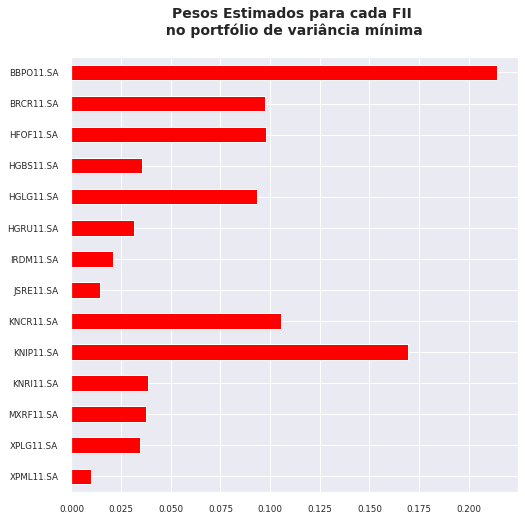

In [119]:
#@title Plotando Pesos (LONG e SHORT)
# acerta a ordem do dicionario para ficar igual a da listagem
import collections
d = collections.OrderedDict(sorted(weights.items(), reverse=True))

# plota
plt.figure(figsize=(8,8))
plt.title('Pesos Estimados para cada FII \n no portfólio de variância mínima \n', fontsize=14, fontweight='bold')

plt.savefig("g-03-port_var_min.svg")
pd.Series(d).plot.barh(color='Red');

**Obs**.: eventuais pesos negativos significam operações SHORT(vendidas) e os positivos, operações LONG(compradas). 

Podemos, agora, obter uma indicação rápida do desempenho deste portfólio em termos de volatilidade da amostra, lembrando que esta poderá ter pouco a ver com o desempenho do portfólio.

In [120]:
#@title Volatilidade Total Estimada do Portfólio
ef.portfolio_performance(verbose=True);

Annual volatility: 5.2%


Digamos que a volatilidade observada para este portfólio seja satisfatória e que decidamos comprar as cotas, segundo os pesos indicados pelo modelo. Para fazer isto, precisaríamos obter **quantidades reais** para que as cotas possam ser compradas no home broker (a menos que pudéssemos adquirir frações de cotas, o que ainda não é o caso da B3).

Suponhamos, ainda, que tivéssemos disponíveis R$100000,00 e que o investidor desejasse que sua posição SHORT não ultrapassasse 10\% (0.10) do total investido. Para que esta restrição possa ser satisfeita, recalcularemos os pesos e indicaremos as quantidades físicas de cada FII a serem compradas/vendidas. Resultados a seguir:

In [121]:
#@title Alocação por Ativo (quantidades de cotas)
from pypfopt import DiscreteAllocation

latest_prices = prices.iloc[-1]  # últimos preços de fechamento no momento da operação
valor_total = 100000
short_size = 0.05

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=valor_total, 
                        short_ratio=short_size)
alloc, saldo = da.lp_portfolio()
print(f"Quantidades de Cotas alocadas por ativo restando BRL ${saldo:.2f} de saldo")
alloc

Quantidades de Cotas alocadas por ativo restando BRL $0.01 de saldo


{'BBPO11.SA': 189,
 'BRCR11.SA': 126,
 'HFOF11.SA': 109,
 'HGBS11.SA': 18,
 'HGLG11.SA': 56,
 'HGRU11.SA': 27,
 'IRDM11.SA': 18,
 'JSRE11.SA': 17,
 'KNCR11.SA': 115,
 'KNIP11.SA': 158,
 'KNRI11.SA': 29,
 'MXRF11.SA': 373,
 'XPLG11.SA': 34,
 'XPML11.SA': 10}

- E a nova visualização das barras seria:

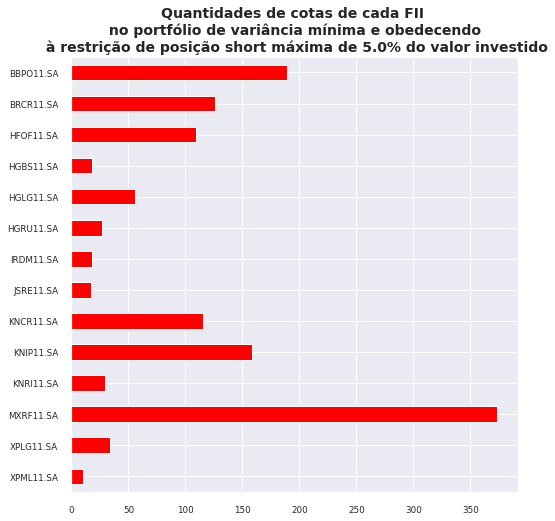

In [122]:
#@title Visualizando as Cotas por Ativo (cotas negativas => SHORT)
# acerta a ordem do dicionario para ficar igual a da listagem
import collections
d = collections.OrderedDict(sorted(alloc.items(), reverse=True))

# plota
plt.figure(figsize=(8, 8))
plt.title('Quantidades de cotas de cada FII \n no portfólio de variância mínima e obedecendo \n à restrição de posição short máxima de '+str(short_size*100)+'% do valor investido', fontsize=14, fontweight='bold')
pd.Series(d).plot.barh(color='Red');
plt.savefig("g-04-port_var_min_c_restr");


In [123]:
#@title Performance do portfólio
ef.portfolio_performance(verbose=True);

Annual volatility: 5.2%


## **5 . Simulação do Portfólio de VARIÂNCIA MÍNIMA**

In [88]:
ef = EfficientFrontier(None, S, weight_bounds=(-1, 1))
ef.min_volatility()
weights = ef.clean_weights();

In [90]:
#@title Conta quantidade de pesos nulos
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

0/14 tickers have zero weight


In [91]:
#@title Performance do Portfólio
ef.portfolio_performance(verbose=True);

Annual volatility: 5.2%


In [92]:
weights

OrderedDict([('KNIP11.SA', 0.1694),
             ('KNRI11.SA', 0.03849),
             ('KNCR11.SA', 0.10528),
             ('HGLG11.SA', 0.09353),
             ('XPLG11.SA', 0.03436),
             ('IRDM11.SA', 0.02081),
             ('MXRF11.SA', 0.0374),
             ('HGRU11.SA', 0.03157),
             ('BRCR11.SA', 0.09747),
             ('HFOF11.SA', 0.0979),
             ('HGBS11.SA', 0.03559),
             ('XPML11.SA', 0.00989),
             ('JSRE11.SA', 0.01434),
             ('BBPO11.SA', 0.21397)])

- Verificando quantos ativos permanecem com pesos zerados, após a regularização.

- Plotando o pie chart do portfólio de retorno máximo para um nível de risco pré-estabelecido.

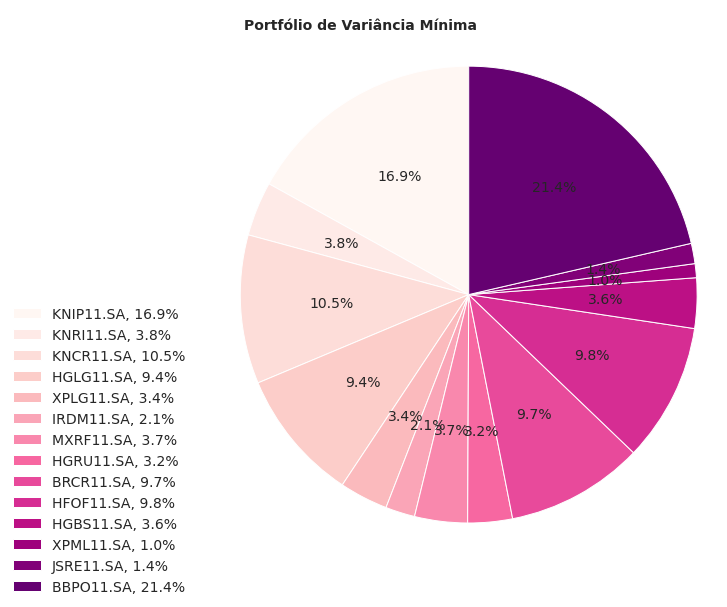

In [96]:
#@title Pie chart
# prepara a plotagem 
#
# cmap mappings themes in 
# https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
#
# percorre o dicionario de pesos e extrai labels e values
w = weights.copy()
labels = []
sizes = []

# lembrar que target_risk já veio definido no cáculo da 
# última ef. calculada para o portifolio

for key, value in w.items():
    labels.append(key)
    sizes.append(value)
 
fig1, ax1 = plt.subplots(figsize=(10, 8))
plt.suptitle('Portfólio de Variância Mínima', fontsize=14, 
          fontweight='bold')
fig1.subplots_adjust(0.3, 0, 1, 1)
 
theme = plt.get_cmap('RdPu')
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes))
                             for i in range(len(sizes))])
 
_, _, autotxts = ax1.pie(sizes, autopct='%1.1f%%', startangle=90, radius=180)

for i in range(len(labels)):
  autotxts[i].set_fontsize(14)

 
ax1.axis('equal')
 
total = sum(sizes)
plt.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100)
            for l, s in zip(labels, sizes)],
    prop={'size': len(sizes)},
    bbox_to_anchor=(0.0, 0.5),
    bbox_transform=fig1.transFigure
)
plt.savefig("g-06-port_ret_max_for_risk.svg")

plt.show();

- Verificando as restrições impostas e demais parâmetros de performance

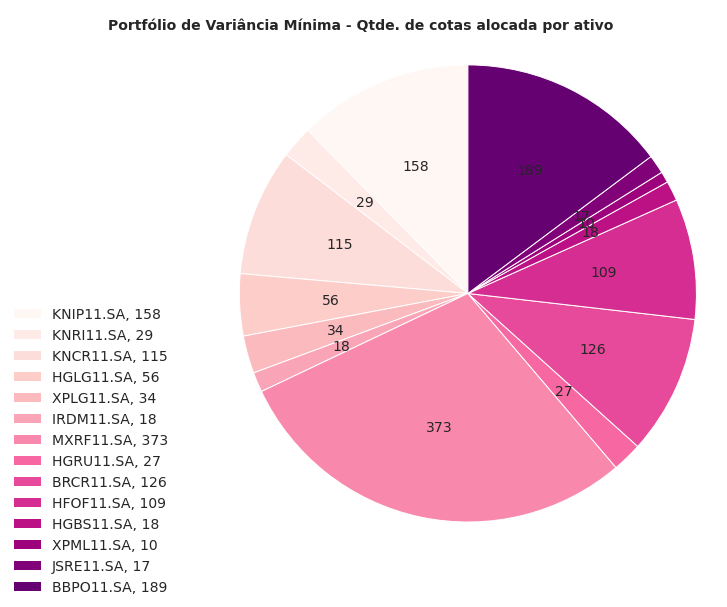

In [168]:
#@title Pie chart - alocação
# prepara a plotagem 
#
# cmap mappings themes in 
# https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
#
# percorre o dicionario de pesos e extrai labels e values

total = sum(sizes)
def absolute_value(val):
  a  = np.round(val/100.*sum(sizes), 0)
  return int(a)

w = alloc.copy()
labels = []
sizes = []

# lembrar que target_risk já veio definido no cáculo da 
# última ef. calculada para o portifolio

for key, value in w.items():
    labels.append(key)
    sizes.append(value)
 
fig1, ax1 = plt.subplots(figsize=(10, 8))
plt.suptitle('Portfólio de Variância Mínima - Qtde. de cotas alocada por ativo', fontsize=14, 
          fontweight='bold')
fig1.subplots_adjust(0.3, 0, 1, 1)
 
theme = plt.get_cmap('RdPu')
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes))
                             for i in range(len(sizes))])
_, _, autotxts = ax1.pie(sizes, autopct=absolute_value,  startangle=90, radius=180)

for i in range(len(labels)):
  autotxts[i].set_fontsize(14)

ax1.axis('equal')
 
total = sum(sizes)
plt.legend(
    loc='upper left',
    labels=['%s, %1.f' % (
        l, int(s))
            for l, s in zip(labels, sizes)],
    prop={'size': len(sizes)},
    bbox_to_anchor=(0.0, 0.5),
    bbox_transform=fig1.transFigure
)

plt.savefig("g-06-port_ret_max_for_risk.svg")

plt.show();